In [1]:
from datasets import load_dataset
from fastai.vision.all import *
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from concept_helpers.DeepView_Craft import CraftTorchDV as Craft
from concept_helpers.combined_crafts import CombinedCrafts
from xplique.attributions.global_sensitivity_analysis import HaltonSequenceRS, JansenEstimator
from xplique.concepts.craft_torch import _batch_inference
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture


from DriftLocalization.j_helper_functions import uncertainty_matrices, entropy_uncertainty
from experiment_helpers.experiment_helper_functions import *

import urllib.request
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import itertools
import torchvision.transforms.functional as F



device = 'cuda' 
# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.to(device)

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in twop arts (as explained in the paper)
# first part is g(.) our 'input_to_latent' model, second part is h(.) our 'latent_to_logit' model
g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer

classifier_head = ClassifierHead(in_features=2048, out_features=10)
classifier_head = classifier_head.to(device)
classifier_head.load_state_dict(torch.load("models/imagewoof_classifier_head.pth"))

with urllib.request.urlopen('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt') as f:
    imagenet_class_names = np.array(f.read().decode('utf-8').split('\n'))


def gen_images(filelist):
    for f in filelist:
        folder_name = f.split('/')[-2]
        class_id = folder_name2class_id[folder_name]
        im = Image.open(f)
        if len(im.getbands()) == 3:
            yield np.array(im.resize((224, 224))), class_id
# Load imagenette dataset
imagewoof_folder = untar_data(URLs.IMAGEWOOF_160)

folders_names = ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601',
                 'n02105641', 'n02111889', 'n02115641']

imagewoof_class_ids = list(range(0, 10))
folder_name2class_id = dict(zip(folders_names, imagewoof_class_ids))

# Get file lists for train, val, and test sets
val_filelist = glob.glob(f'{imagewoof_folder}/val/*/*.JPEG')

# Preprocess train, validation, and test sets in batches
val_images, val_labels = preprocess_images_in_batches(val_filelist,gen_images, transform, to_pil)

def gen_images(filelist,folder_names,folder_name2class_id):
        for f in filelist:
            
            folder_name = f.split('/')[-2]
            if folder_name in folder_names:
                class_id = folder_name2class_id[folder_name]
                im = Image.open(f)
                if len(im.getbands()) == 3:
                    yield np.array(im.resize((224, 224))), class_id

ood_folder = '/home/iroberts/projects/concepts_deepview/data/ninco_all/NINCO/NINCO_OOD_classes'
        
ood_folder_names = os.listdir(ood_folder)
ood_class_names = ood_folder_names

ood_class_ids = [i+1000 for i,class_name in enumerate(ood_class_names)]
ood_folder_name2class_id = dict(zip(ood_folder_names, ood_class_ids))
ood_filelist = glob.glob(f'{ood_folder}/*/*.jpg')

ood_images, ood_labels = zip(*gen_images(ood_filelist,ood_folder_names,ood_folder_name2class_id))
ood_images, ood_labels = np.array(ood_images), np.array(ood_labels)
ood_preprocessed_images = torch.stack([transform(to_pil(img)) for img in ood_images], 0)

def full_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor)
        pred = h(latent).cpu().numpy()
    return pred
    
def latent_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor).cpu().numpy()
            # pred = h(tensor).cpu().numpy()
    return latent

def process_in_batches(data, batch_size, func):
    """
    Process data in batches using the full_wrapper function.

    Args:
        data (np.ndarray): Input data to process.
        batch_size (int): Size of each batch.

    Returns:
        np.ndarray: Predictions for the entire dataset.
    """
    # Initialize an empty list to store predictions
    all_preds = []

    # Iterate over the data in batches
    for start_idx in range(0, len(data), batch_size):
        # Get the end index for the current batch
        end_idx = min(start_idx + batch_size, len(data))
        # Get the current batch
        batch = data[start_idx:end_idx]
        # Use full_wrapper to process the batch and get predictions
        batch_preds = func(batch)
        # Append the predictions to the list
        all_preds.append(batch_preds)

    # Concatenate all batch predictions into a single numpy array
    all_preds = np.concatenate(all_preds, axis=0)
    return all_preds
    
def predict_with_uncertainty_batched(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs,_ in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)


def compute_predictions_sigmoid(inputs):

    inputs = inputs.to(device)
    data_loader = torch.utils.data.DataLoader(inputs, batch_size=64)
    
    predictions = predict_with_uncertainty_batched_sig(stochastic_model, data_loader, n_iter=20, device=device)

    predictions =  predictions.cpu().numpy()
    
    a,prob_mat = uncertainty_matrices(predictions)
    t,e,a = entropy_uncertainty(prob_mat)
    sig_threshold, _, t_norm = get_threshold(t)
    loc = UncertaintyWrapperWithSigmoid(sig_threshold)

    unc_pred_probs = loc.predict_proba(t_norm)
    unc_preds = np.argmax(unc_pred_probs, axis=1)
    return unc_preds, unc_pred_probs

def activation_transform(inputs, patches=False, labels=None, activations=None, n_patches=16):
    """
    Transforms the input images into an (N, 320) representation where N is the number of images.
    
    Parameters:
    - inputs: Input images or data to be transformed.
    - patches: Whether to use patches (if needed for some other functionality).
    - labels: Optional labels for the inputs.
    - activations: Optional pre-computed activations. If None, activations are computed.
    - drift_basis: Predefined basis for NMF.
    - n_patches: Number of patches per image (default is 16).
    
    Returns:
    - transformed_data: Transformed dataset with shape (N, 320).
    """
    
    # Step 1: Extract latent activations using drift_craft
    A = inputs#drift_craft._latent_predict(inputs)  # Assuming A.shape = (N, H, W, D) where D is the activation dimension
    # print(A.shape)
    # Step 2: Reshape activations to 2D (flatten the spatial dimensions)
    original_shape = A.shape[:-1]  # Keep original shape to reconstruct later
    re_activations = np.reshape(A, (-1, A.shape[-1]))
    # print(re_activations.shape)# Flatten to (N * H * W, D)
    # print(re_activations.shape)
    # Step 3: Apply Non-negative Matrix Factorization (NMF) to reduce dimensionality
    
    embedding, basis, n_iter = non_negative_factorization(np.array(re_activations),
                                                          n_components=len(unc_basis),
                                                          init='custom',
                                                          update_H=False, solver='mu', H=unc_basis)

    embedding = np.reshape(embedding, (*original_shape, embedding.shape[-1]))
    # print(embedding.shape)
    
    # Step 4: Reshape the embedding back to the original shape (N, n_patches, n_components)
    # N = 1 # Number of images
    # n_components = embedding.shape[-1]  # Number of concepts (after NMF reduction)
    
    # embedding_reshaped = np.reshape(embedding, (N, n_patches, n_components))  # Reshape back to (N, n_patches, n_components)
    
    # # Step 5: Tile the concepts for each patch to create (N, 320) dataset
    # # Since we need 320 dimensions (n_patches * n_components), we flatten the patches and their concepts
    # transformed_data = embedding_reshaped.reshape(N, -1)  # Shape (N, n_patches * n_components), e.g. (N, 320)

    return embedding
    
def estimate_importance_helper_sigmoid(inputs: np.ndarray = None, class_of_interest: int = None,
                                     nb_design: int = 32, compute_class_importance: bool = False) -> np.ndarray:
        """
        Estimates the importance of each concept for a given class, either globally
        on the whole dataset provided in the fit() method (in this case, inputs shall
        be set to None), or locally on a specific input image.

        Parameters
        ----------
        inputs : numpy array or Tensor
            The input data on which to compute the importances.
            If None, then the inputs provided in the fit() method
            will be used (global importance of the whole dataset).
            Default is None.
        nb_design
            The number of design to use for the importance estimation. Default is 32.

        Returns
        -------
        importances
            The Sobol total index (importance score) for each concept.

        """
        
        coeffs_u = activation_transform(inputs.permute((0,2,3,1)).cpu().numpy())
        # print(coeffs_u.shape)
        # coeffs_u = sigmoidunc_craft.transform(inputs)
        

        masks = HaltonSequenceRS()(len(unc_basis), nb_design=nb_design)
        estimator = JansenEstimator()
        importances = []

        if len(coeffs_u.shape) == 4:
            # for coeff in coeffs_u:
            # apply a re-parameterization trick and use mask on all localization for a given
            # concept id to estimate sobol indices
            for coeff in coeffs_u:
                u_perturbated = masks[:, None, None, :] * coeff[None, :]

                a_perturbated = np.reshape(u_perturbated,
                                           (-1, coeff.shape[-1])) @ unc_basis
                # print("a_perturbed", a_perturbated.shape)
                a_perturbated = np.reshape(a_perturbated,
                                           (len(masks), coeffs_u.shape[1], coeffs_u.shape[2], -1))
                # print("a_perturbed-re", torch.from_numpy(a_perturbated).shape)

                # a_perturbated: (N, H, W, C)
                _,y_pred = compute_predictions_sigmoid(torch.from_numpy(a_perturbated).permute((0,3,1,2)))
                # print("preds",y_pred.shape)

                y_pred = y_pred[:, class_of_interest]
                
                stis = estimator(masks, y_pred, nb_design)

                importances.append(stis)
        
        importances = np.mean(importances, 0)

        # # Save the results of the computation if working on the whole dataset
        if compute_class_importance:
            most_important_concepts = np.argsort(importances)[::-1]
            sigmoidunc_craft.sensitivities[class_of_interest] = Sensitivity(importances, most_important_concepts,
                                                                     cmaps=plt.get_cmap('tab20b').colors + plt.get_cmap('Set3').colors) 

        return importances



import torchvision.transforms.functional as TF
import os
import torch.nn.functional as F

# Gaussian noise function
def gaussian_noise(images, probability=0.5, mean=0, std=1.5):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        add_gaussian_noise(img,mean=mean,std=std) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask


def add_gaussian_noise(image, mean=0, std=1.5):
    noise = torch.randn_like(image) * std + mean
    return torch.clamp(image + noise, 0, 1)

# Salt-and-pepper noise function
def salt_n_pepper(images, probability=0.4, snp_prob=.4): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_salt_and_pepper(img, prob=snp_prob)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_salt_and_pepper(image, prob=0.4):
    mask = torch.rand_like(image[:1])  # Single channel mask
    image = torch.where(mask < prob / 2, torch.tensor(0.0, device=image.device), image)
    image = torch.where(mask > 1 - prob / 2, torch.tensor(1.0, device=image.device), image)
    return image

    # Blurring function
def motion_blurring(images, probability=0.5, kernel_size=None, sigma=None, 
             possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27]):    
    if kernel_size is None:
        kernel_size = random.choice(possible_kernels)
    if sigma is None:
        sigma = np.random.randint(0, 100)

    # Create a mask
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply blurring
    noisy_images = torch.stack([
         add_motion_blur(img, kernel_size=kernel_size) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_motion_blur(image, kernel_size=27):
    kernel = torch.zeros((kernel_size, kernel_size), device=image.device)
    kernel[:, kernel_size // 2] = 1.0 / kernel_size
    kernel = kernel.expand(3, 1, kernel_size, kernel_size)
    return F.conv2d(image.unsqueeze(0), kernel, padding=kernel_size//2, groups=3).squeeze(0)

    
# Blurring function
def gaussian_blurring(images, probability=0.5, kernel_size=None, sigma=None, 
             possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27]):    
    if kernel_size is None:
        kernel_size = random.choice(possible_kernels)
    if sigma is None:
        sigma = np.random.randint(0, 100)

    # Create a mask
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply blurring
    noisy_images = torch.stack([
        add_gaussian_blur(img, kernel_size=kernel_size, sigma=sigma) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_gaussian_blur(image, kernel_size=25, sigma=5):
    return TF.gaussian_blur(image, kernel_size, [sigma, sigma])


# fog noise function
def fog(images, probability=.25, fog_strength=0.85): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_fog(img, fog_strength=fog_strength)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_fog(image, fog_strength=0.85):
    fog = torch.ones_like(image)
    return torch.clamp(image * (1 - fog_strength) + fog * fog_strength, 0, 1)


def chromatic_aberration(images, probability=.25, shift=15): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_chromatic_aberration(img, shift=shift)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_chromatic_aberration(image, shift=25):
    r, g, b = image[0], image[1], image[2]
    r = torch.roll(r, shifts=shift, dims=0)
    b = torch.roll(b, shifts=-shift, dims=0)
    return torch.stack([r, g, b])


def radial_blurring(images, probability=.25, strength=15): 
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply salt-and-pepper noise
    noisy_images = torch.stack([
        add_radial_blur(img, strength=strength)
        if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def add_radial_blur(image, strength=10):
    h, w = image.shape[1:]
    y, x = torch.meshgrid(torch.linspace(-1, 1, h, device=image.device), torch.linspace(-1, 1, w, device=image.device))
    mask = torch.sqrt(x**2 + y**2)
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    blurred = add_gaussian_blur(image, 21, 10)
    return torch.clamp(image * (1 - strength * mask) + blurred * (strength * mask), 0, 1)


# Gaussian noise function
def raining(images, probability=0.5, streak_length=15, density=0.03):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        add_rain(img,streak_length=streak_length, density=density) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask

def add_rain(image, streak_length=15, density=0.07):
    mask = torch.zeros_like(image, device=image.device)
    num_streaks = int(density * image.shape[1] * image.shape[2])
    for _ in range(num_streaks):
        x, y = torch.randint(0, image.shape[2], (1,)), torch.randint(0, image.shape[1], (1,))
        for i in range(streak_length):
            if y + i < image.shape[1]:
                mask[:, y + i, x] = 1.0
    return torch.clamp(image + mask * 0.2, 0, 1)



# Gaussian noise function
def occluding(images, probability=0.5, occlusion_size=0.5):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        apply_occlusion(img,occlusion_size=occlusion_size, mode="black") if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask
    
def apply_occlusion(image, occlusion_size=0.9, mode="black"):
    h, w = image.shape[1:]
    patch_size = int(min(h, w) * occlusion_size)
    x1, y1 = torch.randint(0, w - patch_size, (1,)), torch.randint(0, h - patch_size, (1,))
    occluded_image = image.clone()
    if mode == "black":
        occluded_image[:, y1:y1+patch_size, x1:x1+patch_size] = 0
    elif mode == "white":
        occluded_image[:, y1:y1+patch_size, x1:x1+patch_size] = 1
    return occluded_image



# Gaussian noise function
def wavy(images, probability=0.5, frequency=20, amplitude=15):
    iid_noise_mask = torch.tensor([random.random() < probability for _ in range(images.shape[0])])

    # Apply Gaussian noise
    noisy_images = torch.stack([
        apply_wavy_distortion(img,frequency=frequency, amplitude=amplitude) if iid_noise_mask[i] else img
        for i, img in enumerate(images)
    ])
    return noisy_images, iid_noise_mask

def apply_wavy_distortion(image, frequency=20, amplitude=15):
    """
    Applies a wavy distortion effect to an image using PyTorch.

    Parameters:
        image (torch.Tensor): Input image (C, H, W), values in range [0, 255].
        frequency (int): Controls the number of waves (higher = more waves).
        amplitude (int): The strength of the distortion.
    
    Returns:
        torch.Tensor: Image with wavy distortion applied.
    """
    c, h, w = image.shape  # Get image dimensions
    
    # Generate a sinusoidal wave pattern for vertical displacement
    wave = amplitude * torch.sin(torch.linspace(0, torch.pi * frequency, h, device=image.device))  # Shape: (H,)
    
    # Convert wave values to integer shifts
    wave = wave.round().to(torch.int32)  # Shape: (H,)
    
    # Create an index grid for pixel shifts
    x_grid = torch.arange(w, device=image.device).repeat(h, 1)  # Shape: (H, W)
    x_grid = (x_grid + wave[:, None]) % w  # Apply shift with wrapping
    
    # Expand for each color channel and gather pixels
    x_grid = x_grid.expand(c, h, w)  # Shape: (C, H, W)
    distorted_image = torch.gather(image, 2, x_grid)
    
    return distorted_image





2025-02-27 09:49:52.035917: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from sklearn.mixture import GaussianMixture
noise_dict = {
    'blurred': 'Gaussian Blur', 
    'salt_n_pepper': 'Salt N Pepper Noise', 
'gaussian': 'Gaussian Noise',
'motion':'Motion Blur',
'radial': 'Radial Blur', 
    'wavy': 'Wavy Noise', 
}

528
Fitting Unsupervised Craft....
Fitting Craft....
535
Fitting Unsupervised Craft....
Fitting Craft....
521
Fitting Unsupervised Craft....
Fitting Craft....
540
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
472
Fitting Unsupervised Craft....
Fitting Craft....
476
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
516
Fitting Unsupervised Craft....
Fitting Craft....
564
Fitting Unsupervised Craft....
Fitting Craft....
551
Fitting Unsupervised Craft....
Fitting Craft....
512
Fitting Unsupervised Craft....
Fitting Craft....
519
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:838: RuntimeWarning: Mean of empty slice.
  xbar = data.mean()
/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:884: RuntimeWarning: Degrees of freedom <= 0 for slice
  fac = xbar * (1 - xbar) / data.var(ddof=0) - 1
/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


506
Fitting Unsupervised Craft....
Fitting Craft....
480
Fitting Unsupervised Craft....
Fitting Craft....
523
Fitting Unsupervised Craft....
Fitting Craft....
518
Fitting Unsupervised Craft....
Fitting Craft....
528
Fitting Unsupervised Craft....
Fitting Craft....
511
Fitting Unsupervised Craft....
Fitting Craft....
510
Fitting Unsupervised Craft....
Fitting Craft....
535
Fitting Unsupervised Craft....
Fitting Craft....
521
Fitting Unsupervised Craft....
Fitting Craft....
493
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
518
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
508
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
506
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
515
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
505
Fitting Unsupervised Craft....
Fitting Craft....
528
Fitting Unsupervised Craft....
Fitting Craft....
519
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
479
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
539
Fitting Unsupervised Craft....
Fitting Craft....
491
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
534
Fitting Unsupervised Craft....
Fitting Craft....
474
Fitting Unsupervised Craft....
Fitting Craft....
515
Fitting Unsupervised Craft....
Fitting Craft....
499
Fitting Unsupervised Craft....
Fitting Craft....
502
Fitting Unsupervised Craft....
Fitting Craft....
524
Fitting Unsupervised Craft....
Fitting Craft....
496
Fitting Unsupervised Craft....
Fitting Craft....
506
Fitting Unsupervised Craft....
Fitting Craft....
493
Fitting Unsupervised Craft....
Fitting Craft....
518
Fitting Unsupervised Craft....
Fitting Craft....
481
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
508
Fitting Unsupervised Craft....
Fitting Craft....
511
Fitting Unsupervised Craft....
Fitting Craft....
536
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
507
Fitting Unsupervised Craft....
Fitting Craft....
472
Fitting Unsupervised Craft....
Fitting Craft....
495
Fitting Unsupervised Craft....
Fitting Craft....
531
Fitting Unsupervised Craft....
Fitting Craft....
511
Fitting Unsupervised Craft....
Fitting Craft....
545
Fitting Unsupervised Craft....
Fitting Craft....
527
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
480
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
481
Fitting Unsupervised Craft....
Fitting Craft....
550
Fitting Unsupervised Craft....
Fitting Craft....
531
Fitting Unsupervised Craft....
Fitting Craft....
453
Fitting Unsupervised Craft....
Fitting Craft....
521
Fitting Unsupervised Craft....
Fitting Craft....
514
Fitting Unsupervised Craft....
Fitting Craft....
514
Fitting Unsupervised Craft....
Fitting Craft....
484
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
503
Fitting Unsupervised Craft....
Fitting Craft....
509
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
493
Fitting Unsupervised Craft....
Fitting Craft....
530
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
525
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
513
Fitting Unsupervised Craft....
Fitting Craft....
502
Fitting Unsupervised Craft....
Fitting Craft....
492
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
499
Fitting Unsupervised Craft....
Fitting Craft....
498
Fitting Unsupervised Craft....
Fitting Craft....
498
Fitting Unsupervised Craft....
Fitting Craft....
520
Fitting Unsupervised Craft....
Fitting Craft....
486
Fitting Unsupervised Craft....
Fitting Craft....
488
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
517
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
482
Fitting Unsupervised Craft....
Fitting Craft....
446
Fitting Unsupervised Craft....
Fitting Craft....
522
Fitting Unsupervised Craft....
Fitting Craft....
512
Fitting Unsupervised Craft....
Fitting Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


524
Fitting Unsupervised Craft....
Fitting Craft....
490
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
508
Fitting Unsupervised Craft....
Fitting Craft....
512
Fitting Unsupervised Craft....
Fitting Craft....
504
Fitting Unsupervised Craft....
Fitting Craft....
520
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
504
Fitting Unsupervised Craft....
Fitting Craft....
549
Fitting Unsupervised Craft....
Fitting Craft....
530
Fitting Unsupervised Craft....
Fitting Craft....
577
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
493
Fitting Unsupervised Craft....
Fitting Craft....
550
Fitting Unsupervised Craft....
Fitting Craft....
514
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
508
Fitting Unsupervised Craft....
Fitting Craft....
536
Fitting Unsupervised Craft....
Fitting Craft....
557
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
545
Fitting Unsupervised Craft....
Fitting Craft....
534
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
516
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
470
Fitting Unsupervised Craft....
Fitting Craft....
492
Fitting Unsupervised Craft....
Fitting Craft....
496
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
472
Fitting Unsupervised Craft....
Fitting Craft....
531
Fitting Unsupervised Craft....
Fitting Craft....
471
Fitting Unsupervised Craft....
Fitting Craft....
507
Fitting Unsupervised Craft....
Fitting Craft....
515
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Craft....
514
Fitting Unsupervised Craft....
Fitting Craft....
527
Fitting Unsupervised Craft....
Fitting Craft....
532
Fitting Unsupervised Craft....
Fitting Craft....
493
Fitting Unsupervised Craft....
Fitting Craft....
315
Fitting Unsupervised Craft....
Fitting Craft....
292
Fitting Unsupervised Craft....
Fitting Craft....
484
Fitting Unsupervised Craft....
Fitting Craft....
509
Fitting Unsupervised Craft....
Fitting Craft....
520
Fitting Unsupervised Craft....
Fitting Craft....
540
Fitting Unsupervised Craft....
Fitting Craft....
528
Fitting Unsupervised Craft....
Fitting Craft....
304
Fitting Unsupervised Craft....
Fitting Craft....
530
Fitting Unsupervised Craft....
Fitting Craft....


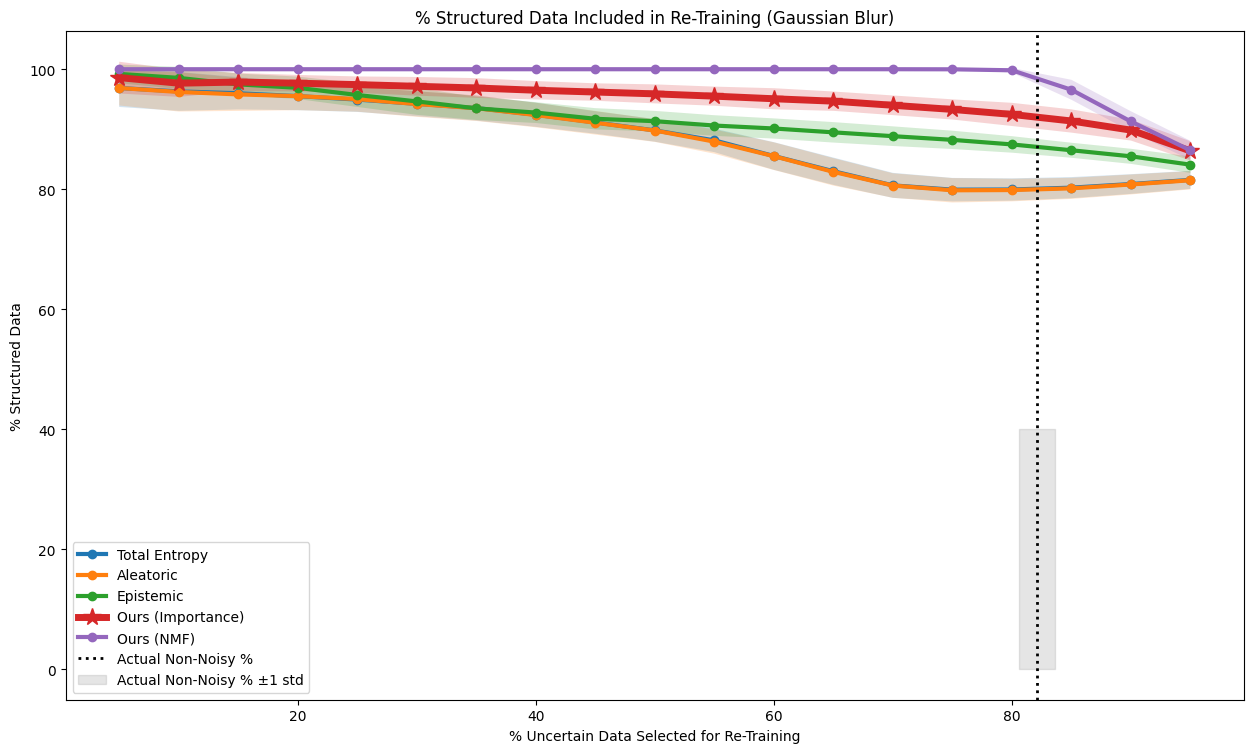

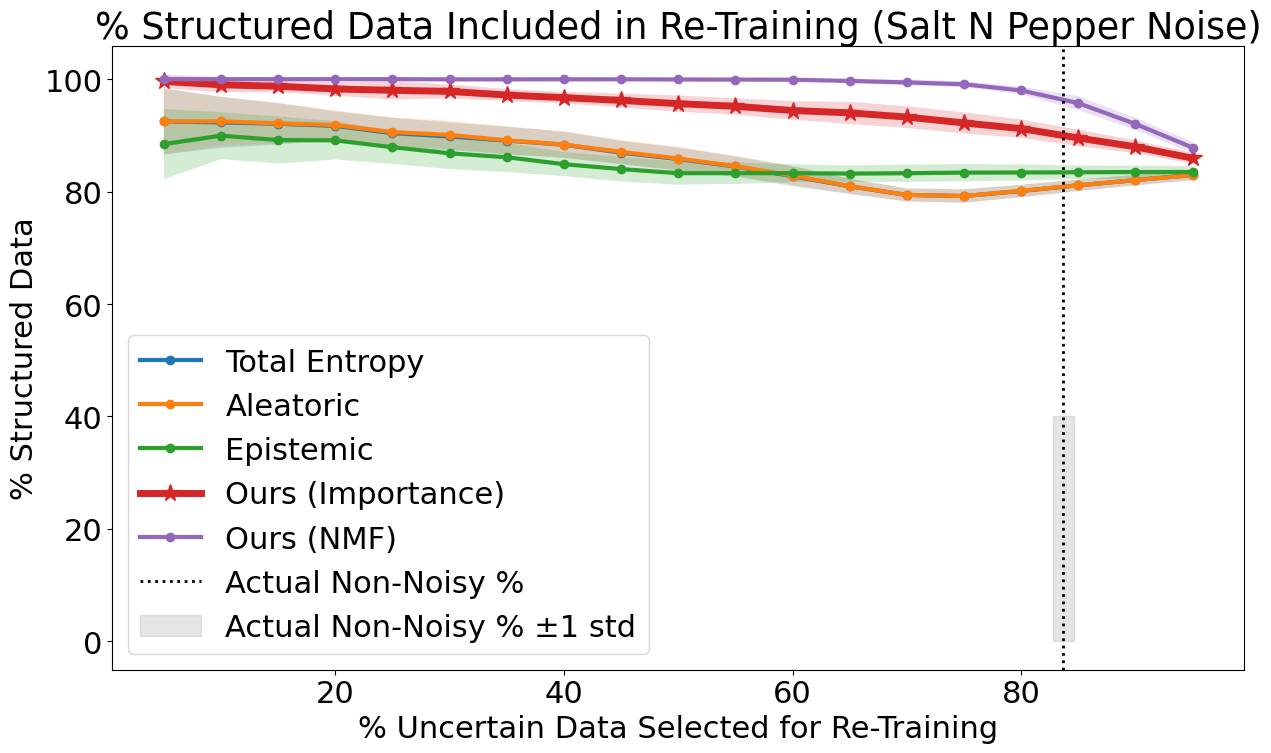

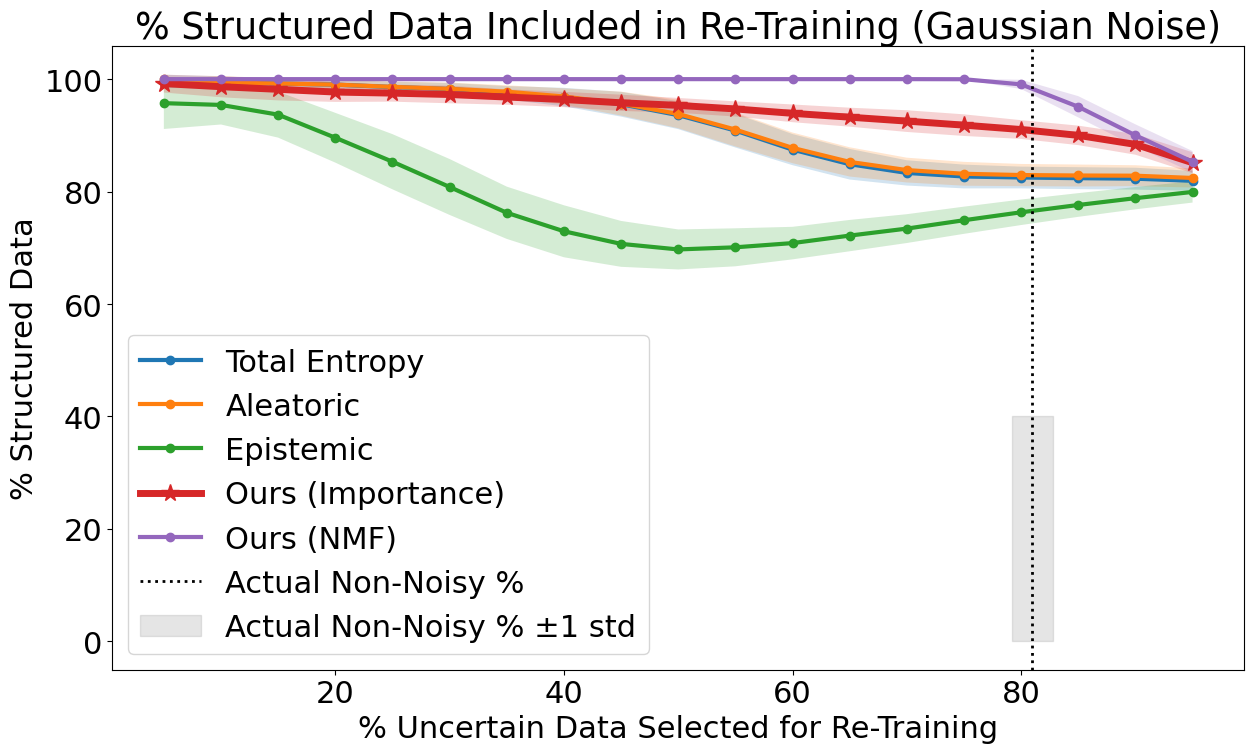

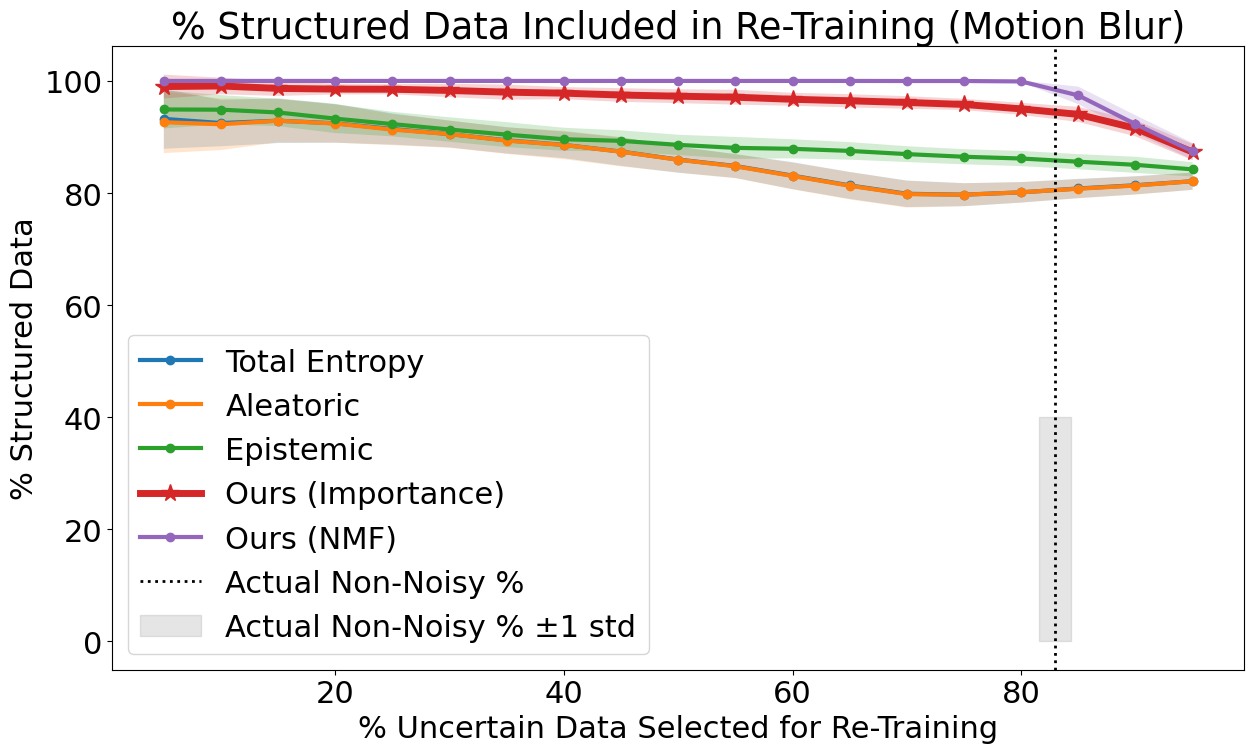

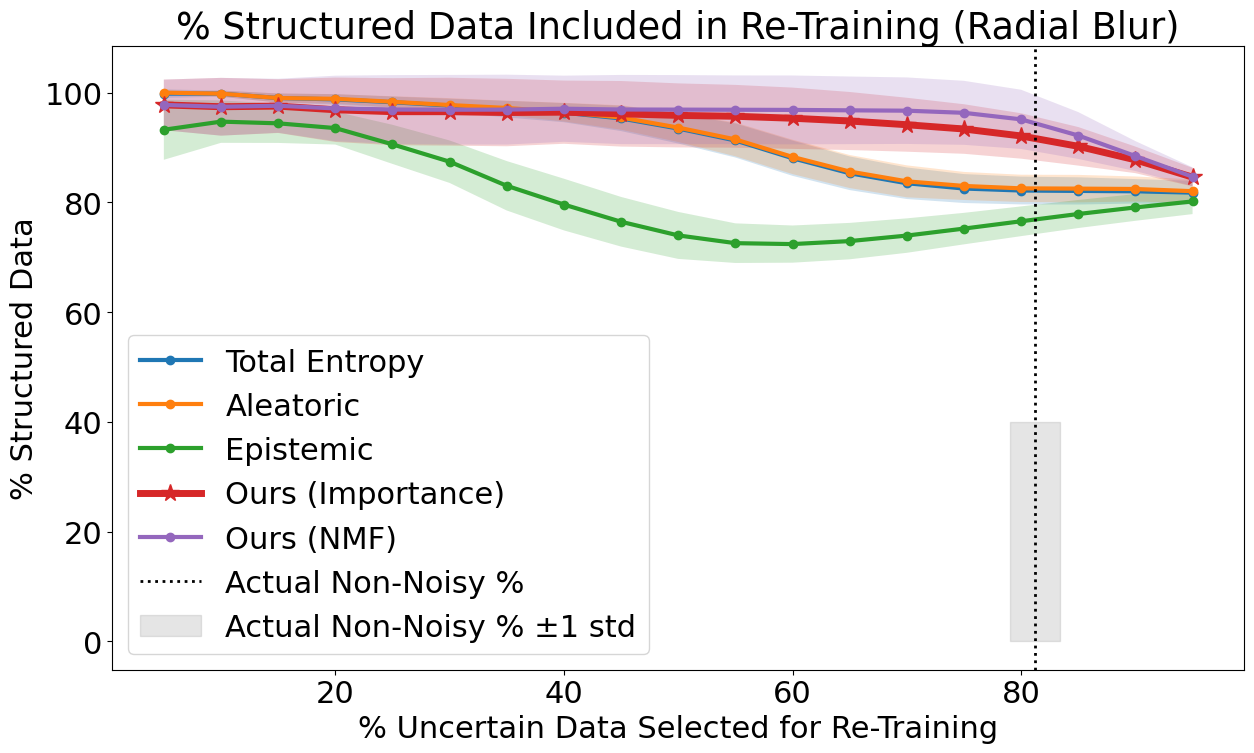

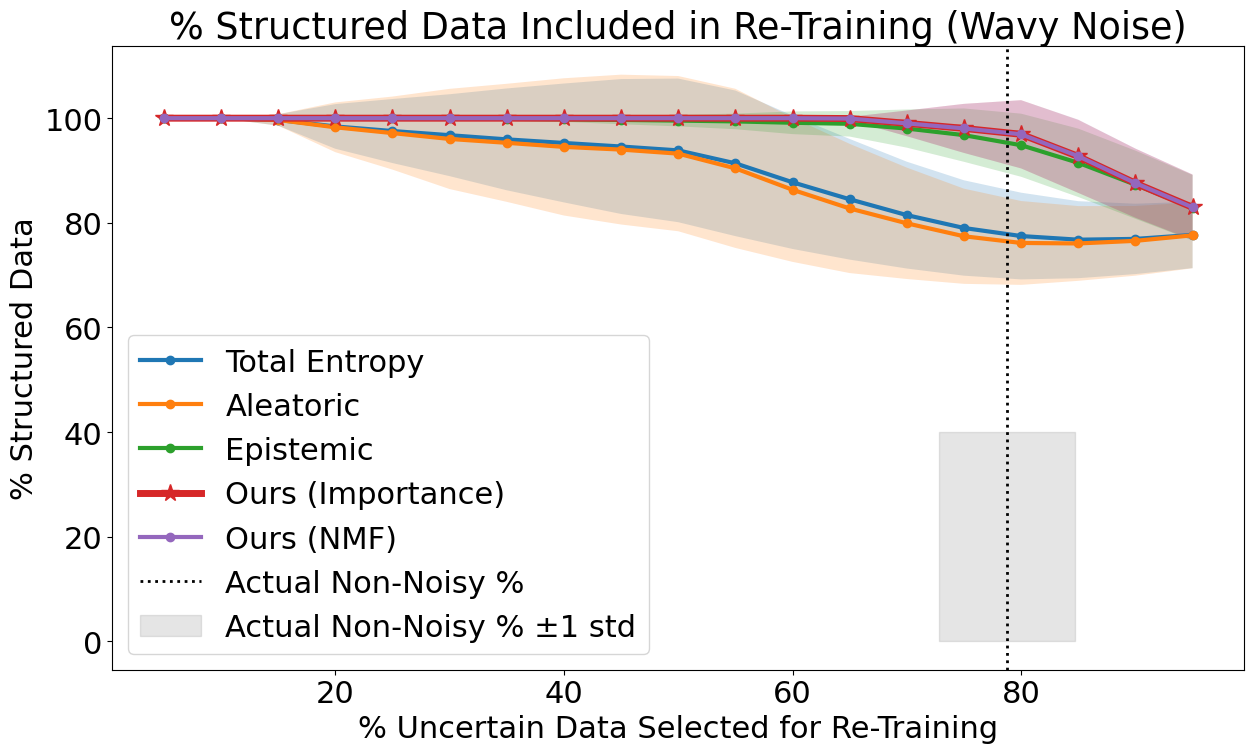

In [3]:
noise_types = ['blurred', 'salt_n_pepper', 'gaussian','motion','radial','chromatic','rain','occlusion','wavy','fog']

# Define k values
percentages = np.arange(5, 100, 5)
runs = 20  # Number of runs per noise type
prob_of_noise = .1

noise_types = ['blurred', 'salt_n_pepper', 'gaussian','motion','radial','wavy']#, 'salt_n_pepper', 'gaussian']
all_results = {noise: { "actual_percentage": [],
     "total_entropy_r": [], "aleatoric_r": [], "epistemic_r": [],
                        
                       "sorted_imp_concepts_percentage": [], "sorted_nmf_concepts_percentage": []
} for noise in noise_types}

all_results_auc = {noise: {
    "total_entropy_r": [], "aleatoric_r": [], "epistemic_r": [],
                       
                       "sorted_imp_concepts_percentage": [], "sorted_nmf_concepts_percentage": []
} for noise in noise_types}

# Run multiple times and collect results
for noise_type in noise_types:
    for _ in range(20):
    
    
        #Sample data from OOD and IDD        
        ood_sample = np.random.choice(len(ood_preprocessed_images),150,False)
        sample_ood_preprocessed_images = ood_preprocessed_images[ood_sample]
        sample_ood_labels = ood_labels[ood_sample]
        
        sample = np.random.choice(len(val_images),1000,False )
        sample_val_images = val_images[sample]
        sample_val_labels = val_labels[sample]
        
        
        
        # Assuming val_images is a batch of images (N, C, H, W)
        
        
        # Apply Noise
        if noise_type == 'blurred':
           noisy_iid_images,iid_noise_mask = gaussian_blurring(sample_val_images, probability=prob_of_noise, kernel_size=21, sigma=10, 
                                                         possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27])
    
        if noise_type == 'salt_n_pepper':
            noisy_iid_images,iid_noise_mask = salt_n_pepper(sample_val_images, probability=prob_of_noise)
        
        
        if noise_type == 'gaussian':
            noisy_iid_images,iid_noise_mask = gaussian_noise(sample_val_images, probability=prob_of_noise, mean=0, std=1.5)
        if noise_type == 'motion':
            noisy_iid_images,iid_noise_mask = motion_blurring(sample_val_images, probability=prob_of_noise, kernel_size=27, sigma=10, 
                                                             possible_kernels=[11, 13, 15, 17, 19, 21, 23, 25, 27])
        if noise_type == 'radial':
            noisy_iid_images,iid_noise_mask = radial_blurring(sample_val_images, probability=prob_of_noise, strength=15)
        if noise_type == 'chromatic':
            noisy_iid_images,iid_noise_mask = chromatic_aberration(sample_val_images, probability=prob_of_noise, shift=15)
        if noise_type == 'rain':
            noisy_iid_images,iid_noise_mask = raining(sample_val_images, probability=prob_of_noise, streak_length=15, density=0.07)
        if noise_type == 'occlusion':
            noisy_iid_images,iid_noise_mask = occluding(sample_val_images, probability=prob_of_noise, occlusion_size=.65)
        if noise_type == 'wavy':
            noisy_iid_images,iid_noise_mask = wavy(sample_val_images, probability=prob_of_noise, frequency=20, amplitude=15)
        if noise_type == 'fog':
            noisy_iid_images,iid_noise_mask = fog(sample_val_images, probability=prob_of_noise, fog_strength=0.99)

        # Step 3: Concatenate IID and OOD data
        idd_embeddings = process_in_batches(noisy_iid_images, 64, latent_wrapper)
        
        ood_embeddings = process_in_batches(sample_ood_preprocessed_images, 64, latent_wrapper)
        
        all_embeddings = torch.cat([torch.from_numpy(idd_embeddings),torch.from_numpy(ood_embeddings)]).to(device)
        all_images = torch.cat([noisy_iid_images, sample_ood_preprocessed_images]).to(device)
        all_labels = torch.from_numpy(np.concatenate([sample_val_labels, sample_ood_labels])).to(device)
        
        
        
        # Step 4: Create a full noise mask that extends to OOD images (which are never noisy)
        full_noise_mask = torch.cat([
            iid_noise_mask,  # This marks noisy IID images
            torch.zeros(sample_ood_preprocessed_images.shape[0], dtype=torch.bool)  # OOD images are never noisy
        ])
        
        # Step 5: Shuffle all data while keeping track of noise
        shuffle_indices = torch.randperm(all_images.shape[0])
        
        shuffled_embeddings = all_embeddings[shuffle_indices]
        shuffled_images = all_images[shuffle_indices]
        shuffled_labels = all_labels[shuffle_indices]
        shuffled_noise_mask = full_noise_mask[shuffle_indices]  # Tracks noisy images after shuffling
        
        #Assign normal labels to OOD and keep track of where they are
        idd_odd_og_labels = shuffled_labels.cpu().numpy()
        
        ood_ind = np.where(idd_odd_og_labels > 999)[0]
        idd_ind = np.where(idd_odd_og_labels <= 999)[0]
        
        idd_odd_labels = idd_odd_og_labels.copy()
        idd_odd_labels[ood_ind] = np.random.choice(np.unique(val_labels), size=len(ood_ind))
        gt_idd_ood = idd_odd_og_labels.copy()
        gt_idd_ood[ood_ind] = 1
        gt_idd_ood[idd_ind] = 0
        
        #Make torch compatible
        idd_odd_labels = torch.from_numpy(idd_odd_labels).to(device)
        dataset = EmbeddingDataset(shuffled_embeddings,idd_odd_labels)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)
        
        # Create stochastic model
        dropout_prob = 0.5
        stochastic_model = StochasticModel(classifier_head, dropout_prob).to(device)
        
        #Get output Distribution
        predictions = predict_with_uncertainty_batched(stochastic_model.to(device), dataloader, n_iter=30)
        predictions = predictions.cpu().numpy()
        

        #Calculate entropy
        a, prob_mat = uncertainty_matrices(predictions)
        t, e, a = entropy_uncertainty(prob_mat)

        # Calculate Variance
        var = 1 -  np.mean(((np.full((prob_mat.shape[0],10),.1) - np.mean(prob_mat,axis=1))**2), axis=1)
                
        
        
        #Get threshold from Gaussian Mixture
        t_min, t_max = np.min(t), np.max(t)
        # Add a small epsilon to ensure values are strictly within (0, 1)
        epsilon = 1e-6
        t_normalized = (t - t_min) / (t_max - t_min)
        t_norm = np.clip(t_normalized, epsilon, 1 - epsilon)
        
        data = t_norm
        # Gaussian Mixture Model to estimate clusters
        gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
        data_reshaped = data.reshape(-1, 1)
        gmm.fit(data_reshaped)
        labels = gmm.predict(data_reshaped)
    
    
        cluster_data0 = data[labels == 0]
        cluster_data1 = data[labels == 1]
    
        if np.mean(cluster_data0) > np.mean(cluster_data1):
            mini = np.min(cluster_data0) 
            maxi = np.max(cluster_data1) 
            threshold = (mini + maxi) / 2
        if np.mean(cluster_data1) > np.mean(cluster_data0):
            mini = np.min(cluster_data1) 
            maxi = np.max(cluster_data0) 
            threshold = (mini + maxi) / 2        
        
        loc = UncertaintyWrapperWithSigmoid(threshold)
        unc_pred_probs = loc.predict_proba(t_norm)
        unc_preds = np.argmax(unc_pred_probs, axis=1)
        
        
        
        
        med_indices = np.where(unc_preds == 1)[0]
        print(len(med_indices))
        
        patch_size=80
        

        #Unc concepts extraction
        med_fit = Craft(input_to_latent_model=g,
                            latent_to_logit_model=classifier_head,
                            number_of_concepts=10,
                            # labels=h_y,
                            patch_size=patch_size,
                            batch_size=64,
                            device=device)
        print("Fitting Unsupervised Craft....")
        med_crops, med_crops_u, med_w = med_fit.fit(shuffled_images[med_indices])
        
        unc_basis = np.vstack([med_w])
        
        
        sigmoidunc_craft = CombinedCrafts(input_to_latent_model=g,
                        latent_to_logit_model=stochastic_model,
                        number_of_concepts=len(unc_basis),
                        inputs=shuffled_images[med_indices],
                        labels=unc_preds[med_indices],
                        basis = unc_basis,
                        batch_size=64,
                        patch_size=patch_size,
                        device=device)
        print("Fitting Craft....")
        sigmoidunc_craft.transform_all()

        #create new groups to distiguish data
        data_groups = idd_odd_labels.cpu().numpy().copy()
        data_groups[ood_ind] = 2
        data_groups[idd_ind] = 0
        data_groups[np.where(shuffled_noise_mask == 1)[0]] = 1

        #Create uncertain groups to distiguish points predicted as uncertain
        uncertain_groups = data_groups[np.where(unc_preds==1)[0]]
        struct_noisy_labels = uncertain_groups.copy()
        struct_noisy_labels[np.where(uncertain_groups == 1)[0]] = 0
        struct_noisy_labels[np.where(uncertain_groups != 1)[0]] = 1


        #Get pathces of images in uncertain class to train human simulator Logisitc Regression
        image_size = (shuffled_images[med_indices].shape[2], shuffled_images[med_indices].shape[3])
        height, width = image_size
        strides = int(sigmoidunc_craft.patch_size * 0.80)
        num_patches_per_image = ((height - sigmoidunc_craft.patch_size) // strides + 1) * ((width - sigmoidunc_craft.patch_size) // strides + 1)

        struct_noisy_patch_labels = np.repeat(struct_noisy_labels, num_patches_per_image)
        
        # num_channels = shuffled_images[med_indices].shape[1]
        # patches = torch.nn.functional.unfold(shuffled_images[med_indices], kernel_size=sigmoidunc_craft.patch_size, stride=strides)
        # patches = patches.transpose(1, 2).contiguous().view(-1, num_channels, sigmoidunc_craft.patch_size, sigmoidunc_craft.patch_size)
        # activations = sigmoidunc_craft._latent_predict(patches, resize=image_size)


        #Train LR on patch nmf activations
        X_train, X_test, y_train, y_test = train_test_split(
            sigmoidunc_craft.factorization.crops_u, struct_noisy_patch_labels, test_size=0.33, random_state=42)
        
        
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)

        #Apply LR to the top 20 patches representing each concept.
        #If sum is less than .05 then we consider it noisy (since noisy is labeled as 0)
        nb_crops = 20
        noisy_concepts = []
        for concept in range(10):
            best_crops_ids = np.argsort(sigmoidunc_craft.factorization.crops_u[:, concept])[::-1][:nb_crops]
            best_crops = np.array(sigmoidunc_craft.factorization.crops_u)[best_crops_ids]
            preds = clf.predict(best_crops)
            if sum(preds) <= .05 * nb_crops:
                noisy_concepts.append(concept)


        #Calculate local importance vectors
        sig_im_imp = np.array([estimate_importance_helper_sigmoid(
            torch.unsqueeze(image,dim=0),class_of_interest=unc_preds[med_indices][i]) 
                               for i,image in enumerate(shuffled_embeddings[med_indices])])
        

        # calculate the importance of the noisy concepts for each local improtance vector and sort them
        # we sort such that the ones which activate the noisy concepts the most are last
        noisy_val_imp_list = []
        for i ,imp in enumerate(sig_im_imp):
            vals = imp[noisy_concepts]
            noisy_val_imp_list.append(vals.sum())
        sorted_noisy_imp_val_list = np.argsort(noisy_val_imp_list)
        

        #calculate the coefficient vectors for each input with the NMF
        sig_im_nmf_act = np.array([nmf_transform(torch.unsqueeze(image,dim=0).permute((0,2,3,1)).cpu().numpy(),unc_basis) 
                                   for i,image in enumerate(shuffled_embeddings[med_indices])])
        sig_im_nmf_act =  sig_im_nmf_act.reshape((len(sig_im_nmf_act), sig_im_nmf_act.shape[2]))


        # calculate the importance of the noisy concepts for each nmf coefficients and sort them
        # we sort such that the ones which activate the noisy concepts the most are last
        noisy_val_nmf_list = []
        for i ,imp in enumerate(sig_im_nmf_act):
            vals = imp[noisy_concepts]
            noisy_val_nmf_list.append(vals.sum())
        sorted_noisy_nmf_val_list = np.argsort(noisy_val_nmf_list)
                
        
        
        

        
        # store the percentage of points recommended for training which are not noisy
        true_totals = []
        # noisy_percentage_baseline_total = []
        # noisy_percentage_baseline_a = []
        # noisy_percentage_baseline_e = []
        noisy_percentage_concepts = []
        noisy_percentage_top1_imp_concepts = []
        noisy_percentage_top1_nmf_concepts = []
        noisy_percentage_top2_imp_concepts = []
        noisy_percentage_top2_nmf_concepts = []
        noisy_percentage_top3_imp_concepts = []
        noisy_percentage_top3_nmf_concepts = []
        noisy_percentage_baseline_total_r = []
        noisy_percentage_baseline_a_r = []
        noisy_percentage_baseline_e_r = []
        # var_baseline = []
        # kl_baseline = []
        var_baseline_r = []
        kl_baseline_r = []
        for percent in percentages:
            k = int(percent * len(med_indices) / 100)  # Convert % to absolute count

            # true_total = np.round((struct_noisy_labels.sum() / len(struct_noisy_labels))*100,2)
            # true_totals.append(true_total)
            # baseline_var = np.round((struct_noisy_labels[np.argsort(var[med_indices])[::-1][:k]].sum() / k)*100,2)
            # var_baseline.append(baseline_var)
            
            baseline_var_r = np.round((struct_noisy_labels[np.argsort(var[med_indices])[:k]].sum() / k)*100,2)
            var_baseline_r.append(baseline_var_r)

            # baseline_kl = np.round((struct_noisy_labels[np.argsort(kl[med_indices])[::-1][:k]].sum() / k)*100,2)
            # kl_baseline.append(baseline_kl)
            
            # baseline_kl_r = np.round((struct_noisy_labels[np.argsort(kl[med_indices])[:k]].sum() / k)*100,2)
            # kl_baseline_r.append(baseline_kl_r)
            
            baseline_total_reversed = np.round((struct_noisy_labels[np.argsort(t[med_indices])[:k]].sum() / k)*100,2)
            noisy_percentage_baseline_total_r.append(baseline_total_reversed)
        
            baseline_a_reversed = np.round((struct_noisy_labels[np.argsort(a[med_indices])[:k]].sum() / k)*100,2)
            noisy_percentage_baseline_a_r.append(baseline_a_reversed)
        
            baseline_e_reversed = np.round((struct_noisy_labels[np.argsort(e[med_indices])[:k]].sum() / k)*100,2)
            noisy_percentage_baseline_e_r.append(baseline_e_reversed)
            
            # baseline_total = np.round((struct_noisy_labels[np.argsort(t[med_indices])[::-1][:k]].sum() / k)*100,2)
            # noisy_percentage_baseline_total.append(baseline_total)
        
            # baseline_a = np.round((struct_noisy_labels[np.argsort(a[med_indices])[::-1][:k]].sum() / k)*100,2)
            # noisy_percentage_baseline_a.append(baseline_a)
        
            # baseline_e = np.round((struct_noisy_labels[np.argsort(e[med_indices])[::-1][:k]].sum() / k)*100,2)
            # noisy_percentage_baseline_e.append(baseline_e)
        
            # concepts_percentage = np.round((struct_noisy_labels[label_id_list[:k]].sum() / k)*100,2)
            # noisy_percentage_concepts.append(concepts_percentage)
            
            sorted_noisy_imp_concepts_percentage = np.round((struct_noisy_labels[sorted_noisy_imp_val_list[:k]].sum() / k)*100,2)
            noisy_percentage_top1_imp_concepts.append(sorted_noisy_imp_concepts_percentage)
            
            sorted_noisy_nmf_concepts_percentage = np.round((struct_noisy_labels[sorted_noisy_nmf_val_list[:k]].sum() / k)*100,2)
            noisy_percentage_top1_nmf_concepts.append(sorted_noisy_nmf_concepts_percentage)

        true_total = np.round((1 - (struct_noisy_labels.sum() / len(struct_noisy_labels)))*100,2)
        true_totals.append(true_total)
        all_results[noise_type]["actual_percentage"].append(true_totals)    
        # all_results[noise_type]["total_entropy"].append(noisy_percentage_baseline_total)
        # all_results[noise_type]["aleatoric"].append(noisy_percentage_baseline_a)
        # all_results[noise_type]["epistemic"].append(noisy_percentage_baseline_e)
        all_results[noise_type]["total_entropy_r"].append(noisy_percentage_baseline_total_r)
        all_results[noise_type]["aleatoric_r"].append(noisy_percentage_baseline_a_r)
        all_results[noise_type]["epistemic_r"].append(noisy_percentage_baseline_e_r)
        # all_results[noise_type]["var"].append(var_baseline)
        # all_results[noise_type]["var_r"].append(var_baseline_r)
        # all_results[noise_type]["kl"].append(kl_baseline)
        # all_results[noise_type]["kl_r"].append(kl_baseline_r)
        # all_results[noise_type]["concepts"].append(noisy_percentage_concepts)
        all_results[noise_type]["sorted_imp_concepts_percentage"].append(noisy_percentage_top1_imp_concepts)
        all_results[noise_type]["sorted_nmf_concepts_percentage"].append(noisy_percentage_top1_nmf_concepts)



figs_dir = "noise/second/figs"
csv_dir = "noise/second/csvs"
auc_dir = "noise/second/auc"
os.makedirs(figs_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)  # Directory for CSV files
os.makedirs(auc_dir, exist_ok=True)

for noise in noise_types:
    # Compute mean and standard deviation for each metric
    avg_results = {key: np.mean(np.array(values), axis=0) for key, values in all_results[noise].items()}
    std_results = {key: np.std(np.array(values), axis=0) for key, values in all_results[noise].items()}

    # Actual percentage of noisy points (mean and std)
    actual_noisy_percentage = avg_results["actual_percentage"]
    actual_noisy_std = std_results["actual_percentage"]

    # Create a new figure
    plt.figure(figsize=(13, 8))

    # Define method labels
    methods = {
        # "total_entropy": "Total Entropy",
        # "aleatoric": "Aleatoric",
        # "epistemic": "Epistemic",
        "total_entropy_r": "Total Entropy",
        "aleatoric_r": "Aleatoric",
        "epistemic_r": "Epistemic",
        # "var": "Variance",
        # "var_r": "Variance",
        # "kl": "K-L",
        # "kl_r": "K-L",
        "sorted_imp_concepts_percentage": "Ours (Importance)",
        "sorted_nmf_concepts_percentage": "Ours (NMF)"
    }

    # Create a DataFrame to store CSV results
    csv_data = {"Method": []}

    for p in percentages:
        csv_data[f"{p}%"] = []

    for key, label in methods.items():
        mean_values = avg_results[key]
        std_values = std_results[key]

        # Apply small jitter to "Ours NMF" if it overlaps "Ours Importance"
        if key == "sorted_imp_concepts_percentage":
            plt.plot(percentages, mean_values, label=label, linewidth=5, marker="*",markersize=13)
        else: 
        # Plot with shaded standard deviation
            plt.plot(percentages, mean_values, label=label, linewidth=3, marker="o")
        plt.fill_between(percentages, mean_values - std_values, mean_values + std_values, alpha=0.2)

        # Save to CSV data
        csv_data["Method"].append(label)
        for i, p in enumerate(percentages):
            csv_data[f"{p}%"].append(mean_values[i])

    # Add horizontal dotted line for actual noisy percentage
    plt.axvline(100 - actual_noisy_percentage, color="black", linestyle="dotted", linewidth=2, label="Actual Non-Noisy %")

    # Shaded region for standard deviation of actual noisy percentage
    plt.fill_betweenx(
        y=[0, 40],  # Extend from bottom to top
        x1=100 - (actual_noisy_percentage + actual_noisy_std),
        x2=100 - (actual_noisy_percentage - actual_noisy_std),
        color="gray",
        alpha=0.2,
        label="Actual Non-Noisy % ±1 std"
    )

    # Formatting
    plt.xlabel("% Uncertain Data Selected for Re-Training")
    plt.ylabel("% Structured Data")
    plt.title(f"% Structured Data Included in Re-Training ({noise_dict[noise]})")
    plt.legend()
    plt.rcParams.update({'font.size': 22})
    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(figs_dir, f"noisy_data_percentage_{noise}.png")
    plt.savefig(fig_path, dpi=330)
    plt.show()

    # # Save CSV file
    csv_path = os.path.join(csv_dir, f"noisy_data_results_{noise}.csv")
    df = pd.DataFrame(csv_data)
    df.to_csv(csv_path, index=False)

for noise in noise_types:
    for method, res in all_results[noise].items():
        if method == 'actual_percentage':
            pass
        else:
            all_results_auc[noise][method].extend(np.trapz(res, percentages/100))
            
auc_path = os.path.join(auc_dir, f"auc_results_{noise}.csv")
auc_df = pd.DataFrame(all_results_auc)
auc_df.to_csv(auc_path, index_label="method")


[1.49296978]


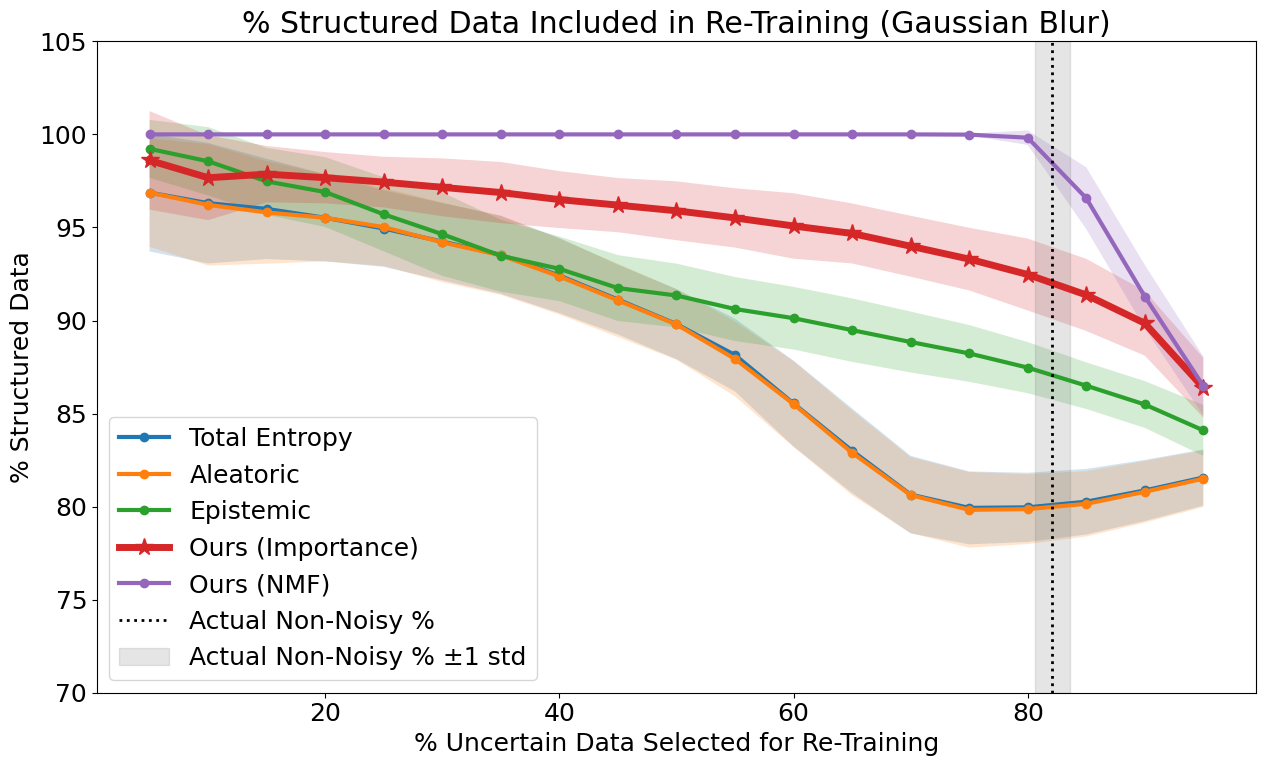

[0.91406838]


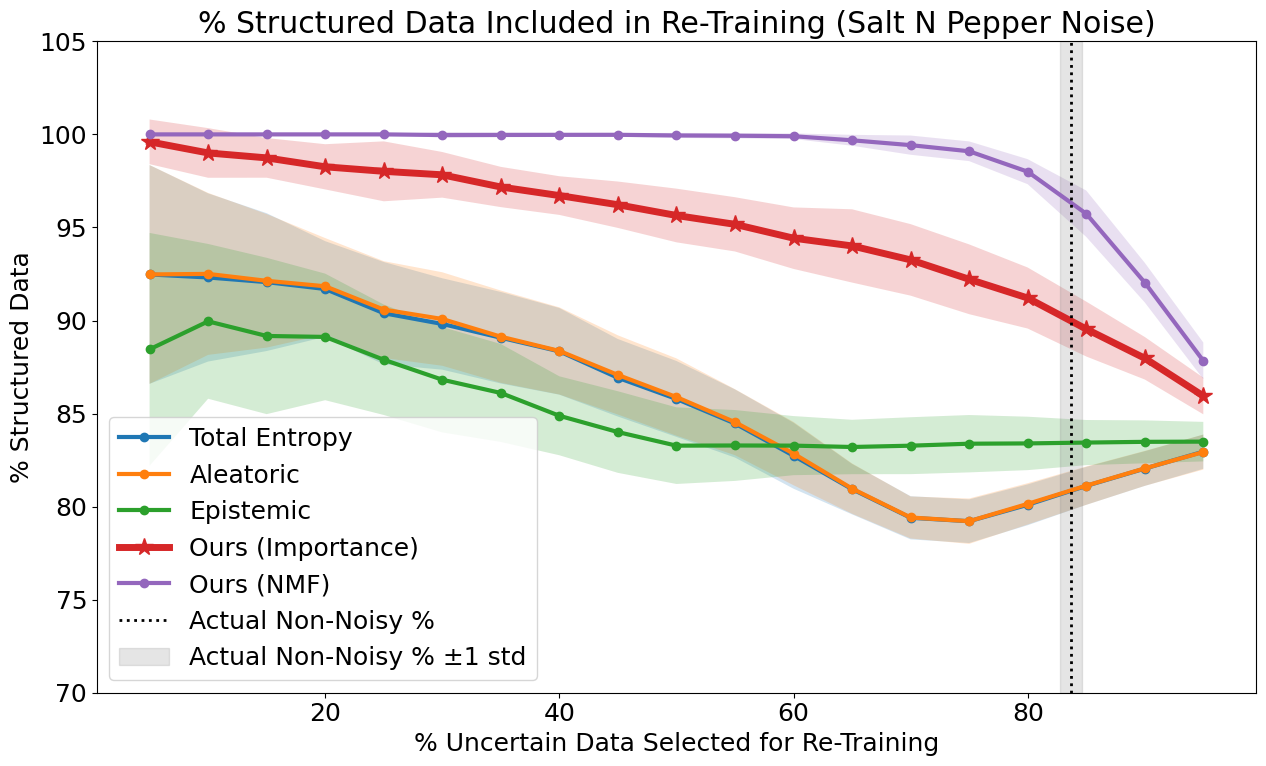

[1.79772328]


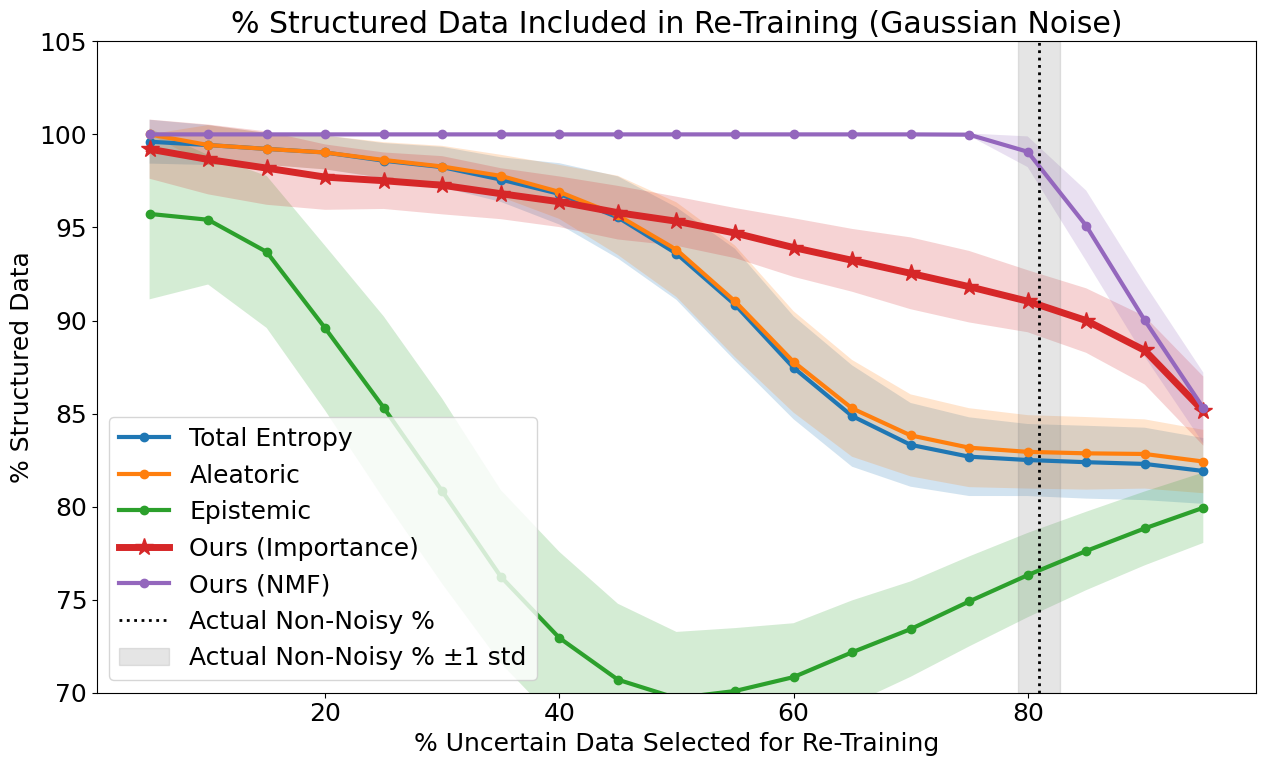

[1.42572394]


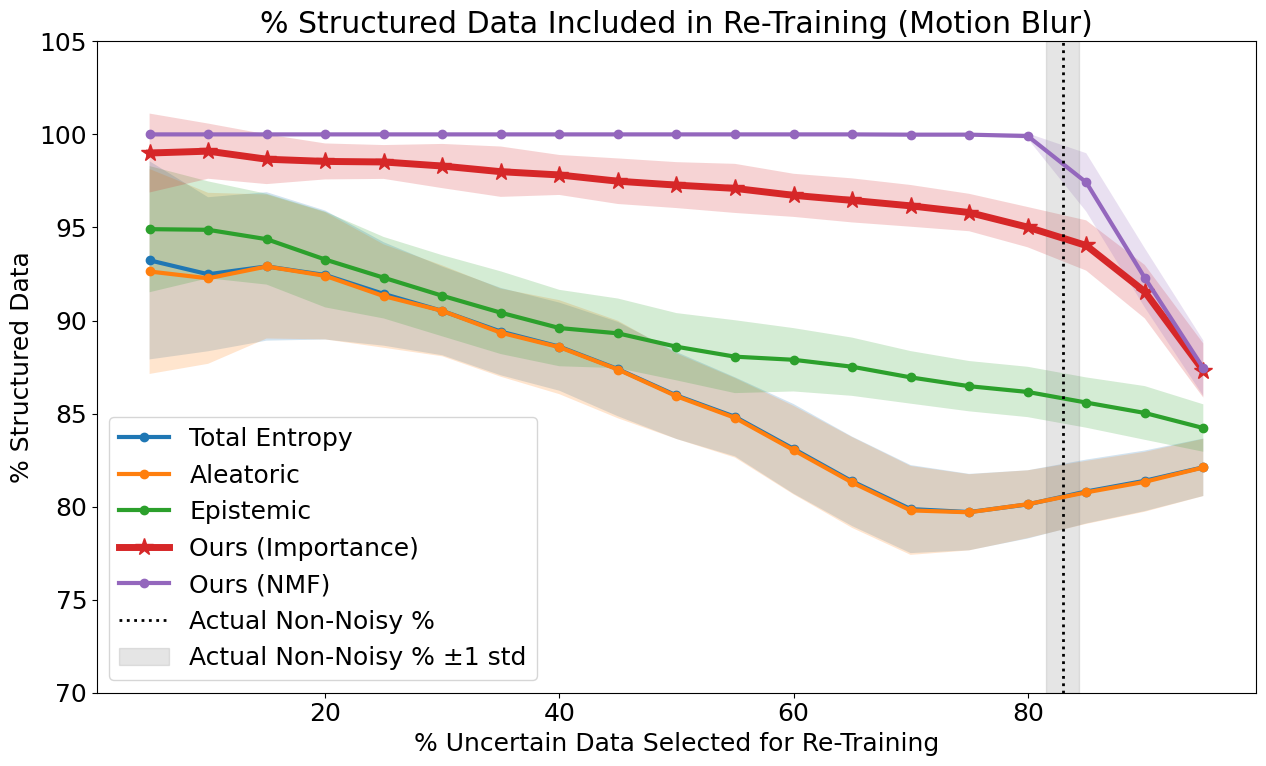

[2.18811129]


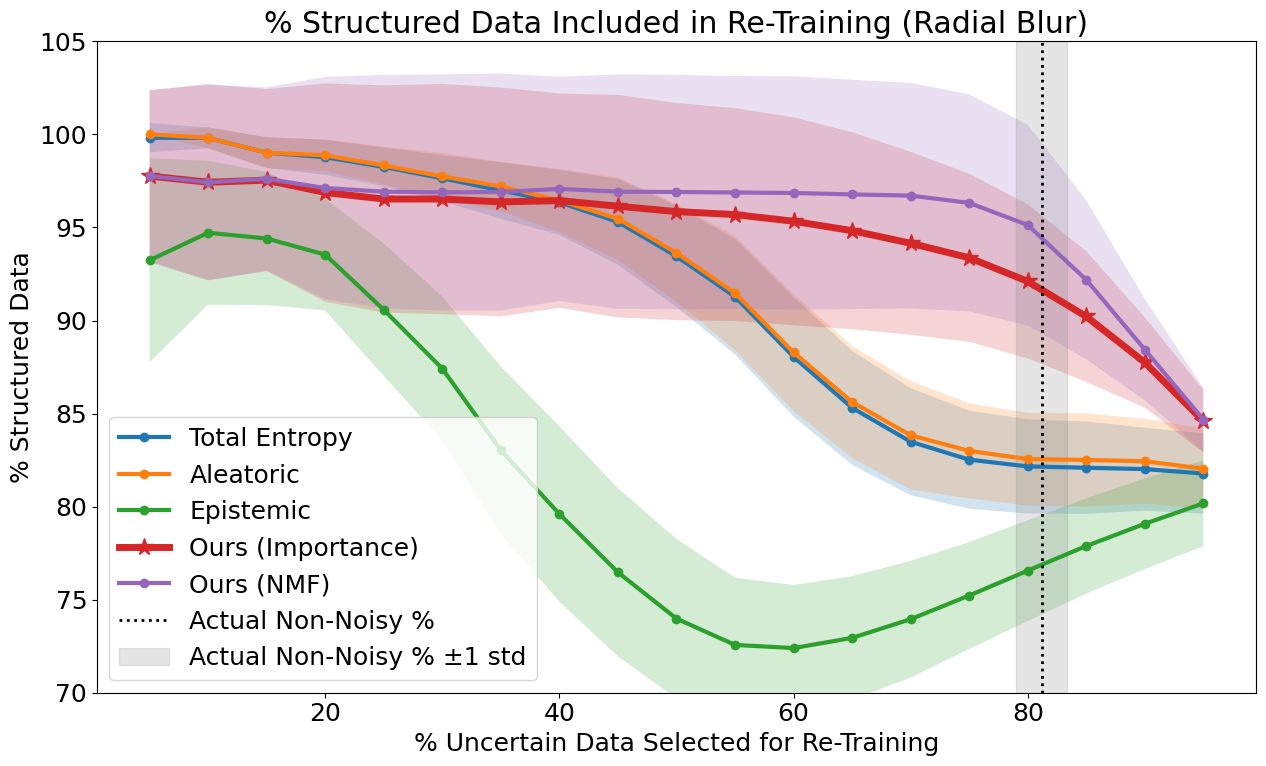

[5.9616344]


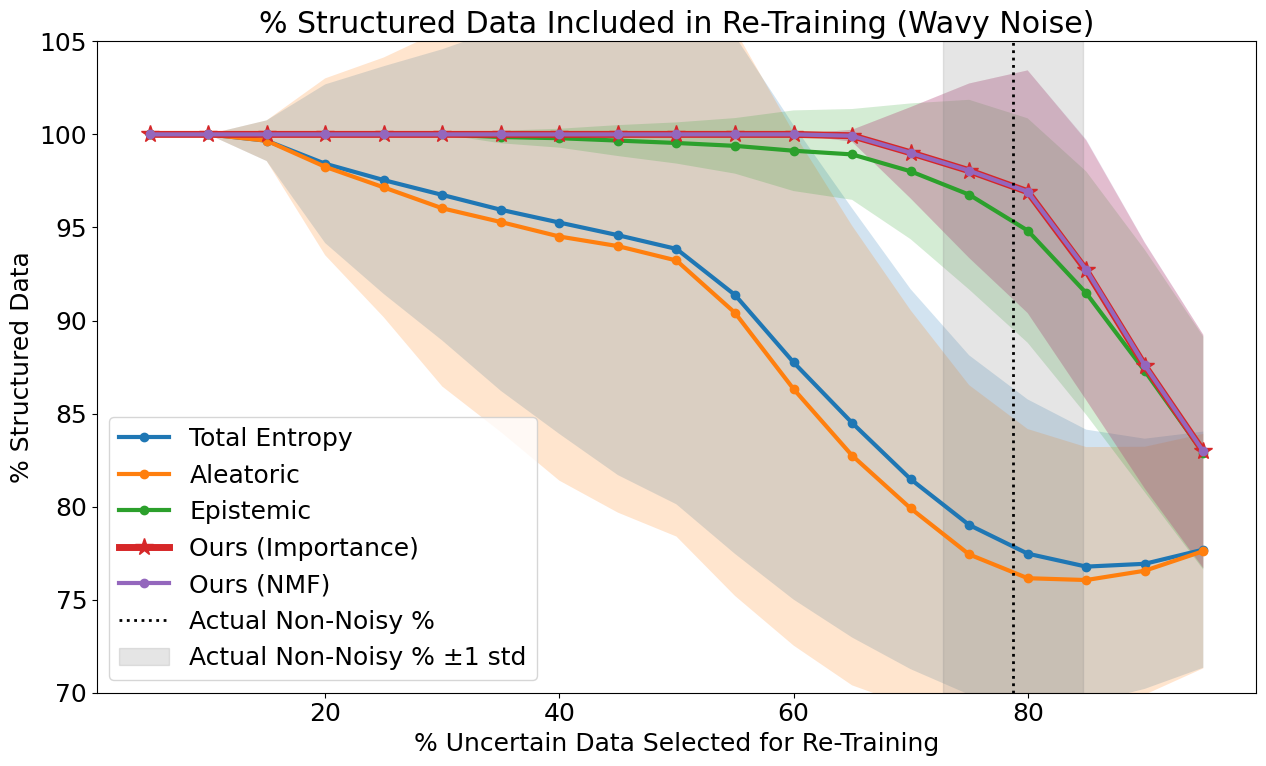

In [34]:
for noise in noise_types:
    # Compute mean and standard deviation for each metric
    avg_results = {key: np.mean(np.array(values), axis=0) for key, values in all_results[noise].items()}
    std_results = {key: np.std(np.array(values), axis=0) for key, values in all_results[noise].items()}

    # Actual percentage of noisy points (mean and std)
    actual_noisy_percentage = avg_results["actual_percentage"]
    actual_noisy_std = std_results["actual_percentage"]
    print(actual_noisy_std)

    # Create a new figure
    plt.figure(figsize=(13, 8))

    # Define method labels
    methods = {
        # "total_entropy": "Total Entropy",
        # "aleatoric": "Aleatoric",
        # "epistemic": "Epistemic",
        "total_entropy_r": "Total Entropy",
        "aleatoric_r": "Aleatoric",
        "epistemic_r": "Epistemic",
        # "var": "Variance",
        # "var_r": "Variance",
        # "kl": "K-L",
        # "kl_r": "K-L",
        "sorted_imp_concepts_percentage": "Ours (Importance)",
        "sorted_nmf_concepts_percentage": "Ours (NMF)"
    }

    # Create a DataFrame to store CSV results
    csv_data = {"Method": []}

    for p in percentages:
        csv_data[f"{p}%"] = []

    for key, label in methods.items():
        mean_values = avg_results[key]
        std_values = std_results[key]

        # Apply small jitter to "Ours NMF" if it overlaps "Ours Importance"
        if key == "sorted_imp_concepts_percentage":
            plt.plot(percentages, mean_values, label=label, linewidth=5, marker="*",markersize=13)
        else: 
        # Plot with shaded standard deviation
            plt.plot(percentages, mean_values, label=label, linewidth=3, marker="o")
        plt.fill_between(percentages, mean_values - std_values, mean_values + std_values, alpha=0.2)

        # Save to CSV data
        csv_data["Method"].append(label)
        for i, p in enumerate(percentages):
            csv_data[f"{p}%"].append(mean_values[i])

    # Add horizontal dotted line for actual noisy percentage
    plt.axvline(100 - actual_noisy_percentage, color="black", linestyle="dotted", linewidth=2, label="Actual Non-Noisy %")

    # Shaded region for standard deviation of actual noisy percentage
    plt.fill_betweenx(
        y=[70, 105],  # Extend from bottom to top
        x1=100 - (actual_noisy_percentage + actual_noisy_std),
        x2=100 - (actual_noisy_percentage - actual_noisy_std),
        color="gray",
        alpha=0.2,
        label="Actual Non-Noisy % ±1 std"
    )

    # Formatting
    plt.xlabel("% Uncertain Data Selected for Re-Training")
    plt.ylabel("% Structured Data")
    plt.title(f"% Structured Data Included in Re-Training ({noise_dict[noise]})")
    plt.legend()
    plt.rcParams.update({'font.size': 18})
    plt.ylim(70, 105)
    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(figs_dir, f"noisy_data_percentage_{noise}.png")
    plt.savefig(fig_path, dpi=330)
    plt.show()

In [10]:
import pandas as pd 

df = pd.read_csv('./Experiment2_results/AUC_results/auc_results.csv',index_col='method')

In [11]:
import ast
df_avg = df.applymap(lambda x: sum(ast.literal_eval(x)) / len(ast.literal_eval(x)))

/tmp/ipykernel_2473769/2748449908.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_avg = df.applymap(lambda x: sum(ast.literal_eval(x)) / len(ast.literal_eval(x)))


In [12]:
df_avg

,blurred,salt_n_pepper,gaussian,motion,radial,wavy
method,,,,,,
total_entropy_r,79.572650,77.205837,82.257075,77.499512,82.164312,80.807600
aleatoric_r,79.514163,77.280637,82.481613,77.439988,82.362300,80.125325
epistemic_r,82.551725,76.696225,70.821537,80.364262,73.052575,87.804800
sorted_imp_concepts_percentage,85.600775,85.407638,85.072300,86.984775,85.216287,88.282888
sorted_nmf_concepts_percentage,89.045850,88.877413,88.839712,89.165800,86.213925,88.285612


In [13]:
df_std = df.applymap(lambda x: np.std(ast.literal_eval(x)))

/tmp/ipykernel_2473769/2532093410.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_std = df.applymap(lambda x: np.std(ast.literal_eval(x)))


In [14]:
df_std

,blurred,salt_n_pepper,gaussian,motion,radial,wavy
method,,,,,,
total_entropy_r,1.456275,1.396095,1.310390,1.980909,1.635902,7.404002
aleatoric_r,1.483614,1.392920,1.280631,2.016665,1.612495,7.994891
epistemic_r,1.240747,1.711592,2.749378,1.422853,2.853465,1.963220
sorted_imp_concepts_percentage,1.258346,0.886438,1.205932,0.912418,4.429845,1.511994
sorted_nmf_concepts_percentage,0.221185,0.192181,0.277762,0.197727,4.893871,1.513173


In [20]:
import pandas as pd

def create_latex_table(avg_df: pd.DataFrame, std_df: pd.DataFrame) -> str:
    """
    Generates a LaTeX table combining average and standard deviation values.
    
    Parameters:
    avg_df (pd.DataFrame): DataFrame containing average values.
    std_df (pd.DataFrame): DataFrame containing standard deviation values.
    
    Returns:
    str: LaTeX formatted table as a string.
    """
    # Ensure both DataFrames have the same structure
    assert avg_df.shape == std_df.shape, "DataFrames must have the same shape"
    assert (avg_df.index == std_df.index).all(), "Row indices must match"
    assert (avg_df.columns == std_df.columns).all(), "Column names must match"
    
    # Create a combined DataFrame with "avg ± std" format
    combined_df = avg_df.copy()
    for col in avg_df.columns:
        combined_df[col] = "$" + avg_df[col].round(1).astype(str) + " \pm " + std_df[col].round(1).astype(str) + "$"
    
    # Convert to LaTeX table
    latex_table = combined_df.to_latex(escape=False)
    
    return latex_table

# Example usage:
# avg_df = pd.DataFrame({"A": [1.2, 2.3], "B": [3.4, 4.5]}, index=["Method1", "Method2"])
# std_df = pd.DataFrame({"A": [0.1, 0.2], "B": [0.3, 0.4]}, index=["Method1", "Method2"])
print(create_latex_table(df_avg, df_std))


\begin{tabular}{lllllll}
\toprule
 & blurred & salt_n_pepper & gaussian & motion & radial & wavy \\
method &  &  &  &  &  &  \\
\midrule
total_entropy_r & $79.6 \pm 1.5$ & $77.2 \pm 1.4$ & $82.3 \pm 1.3$ & $77.5 \pm 2.0$ & $82.2 \pm 1.6$ & $80.8 \pm 7.4$ \\
aleatoric_r & $79.5 \pm 1.5$ & $77.3 \pm 1.4$ & $82.5 \pm 1.3$ & $77.4 \pm 2.0$ & $82.4 \pm 1.6$ & $80.1 \pm 8.0$ \\
epistemic_r & $82.6 \pm 1.2$ & $76.7 \pm 1.7$ & $70.8 \pm 2.7$ & $80.4 \pm 1.4$ & $73.1 \pm 2.9$ & $87.8 \pm 2.0$ \\
sorted_imp_concepts_percentage & $85.6 \pm 1.3$ & $85.4 \pm 0.9$ & $85.1 \pm 1.2$ & $87.0 \pm 0.9$ & $85.2 \pm 4.4$ & $88.3 \pm 1.5$ \\
sorted_nmf_concepts_percentage & $89.0 \pm 0.2$ & $88.9 \pm 0.2$ & $88.8 \pm 0.3$ & $89.2 \pm 0.2$ & $86.2 \pm 4.9$ & $88.3 \pm 1.5$ \\
\bottomrule
\end{tabular}


In [30]:
import pandas as pd

def create_latex_table_with_transpose(avg_df, std_df):
    # Combine the average and standard deviation into a single formatted value
    combined_df = "$" + avg_df.round(1).astype(str) + "\pm " + std_df.round(1).astype(str) + "$"
    
    # Transpose the dataframe
    transposed_df = combined_df.T

    # Compute the mean of the average values (ignoring the standard deviation part)
    avg_of_avgs = avg_df.mean(axis=1).round(1)  # Mean of each column (i.e., across methods)

    # Add the row for the average of averages
    transposed_df["Average"] = avg_of_avgs.astype(str)

    # Convert to LaTeX table format
    latex_table = transposed_df.to_latex(escape=False)

    return latex_table

create_latex_table_with_transpose(df_avg, df_std)

'\\begin{tabular}{lllllll}\n\\toprule\nmethod & total_entropy_r & aleatoric_r & epistemic_r & sorted_imp_concepts_percentage & sorted_nmf_concepts_percentage & Average \\\\\n\\midrule\nblurred & $79.6\\pm 1.5$ & $79.5\\pm 1.5$ & $82.6\\pm 1.2$ & $85.6\\pm 1.3$ & $89.0\\pm 0.2$ & NaN \\\\\nsalt_n_pepper & $77.2\\pm 1.4$ & $77.3\\pm 1.4$ & $76.7\\pm 1.7$ & $85.4\\pm 0.9$ & $88.9\\pm 0.2$ & NaN \\\\\ngaussian & $82.3\\pm 1.3$ & $82.5\\pm 1.3$ & $70.8\\pm 2.7$ & $85.1\\pm 1.2$ & $88.8\\pm 0.3$ & NaN \\\\\nmotion & $77.5\\pm 2.0$ & $77.4\\pm 2.0$ & $80.4\\pm 1.4$ & $87.0\\pm 0.9$ & $89.2\\pm 0.2$ & NaN \\\\\nradial & $82.2\\pm 1.6$ & $82.4\\pm 1.6$ & $73.1\\pm 2.9$ & $85.2\\pm 4.4$ & $86.2\\pm 4.9$ & NaN \\\\\nwavy & $80.8\\pm 7.4$ & $80.1\\pm 8.0$ & $87.8\\pm 2.0$ & $88.3\\pm 1.5$ & $88.3\\pm 1.5$ & NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

In [31]:
df_avg.mean(axis=1).round(1)

method
total_entropy_r                   79.9
aleatoric_r                       79.9
epistemic_r                       78.5
sorted_imp_concepts_percentage    86.1
sorted_nmf_concepts_percentage    88.4
dtype: float64